In [1]:
import os
os.environ['OMP_NUM_THREADS']='3'

import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator

from dolfin import *

import sys
sys.path.insert(0, '../../')
import reaktoro_transport.solver as solver
import reaktoro_transport.tools as tools

%matplotlib inline

In [2]:
# Reading mesh and MeshFunction that stores the fluid solid markers
mesh_xdmf = Mesh()

xdmf_obj = XDMFFile(MPI.comm_world, 'mesh.xdmf')
xdmf_obj.read(mesh_xdmf)

phi_DG_MF = MeshFunction('size_t', mesh_xdmf, dim=2)

xdmf_obj.read(phi_DG_MF)
xdmf_obj.close()

boundary_markers = MeshFunction('size_t', mesh_xdmf, dim=1)

xdmf_obj = XDMFFile(MPI.comm_world, 'boundary.xdmf')
xdmf_obj.read(boundary_markers)

V = FunctionSpace(mesh_xdmf, 'DG', 0)
phi_DG = Function(V)
phi_DG.vector()[:] = phi_DG_MF.array()[:]

xdmf_obj.close()

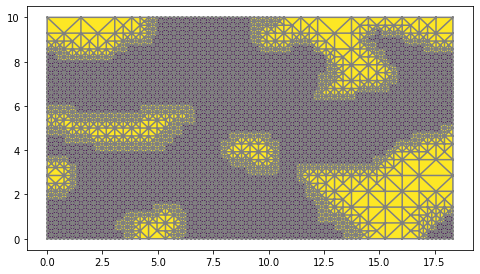

In [3]:
# Plot and show if mesh is properly read
plt.figure(figsize=(8,8))
plot(phi_DG_MF)
plot(mesh_xdmf)
plt.show()

In [4]:
# Defining the inlet and noslip boundary markers
b_dict = {'inlet': [2, 3], 'noslip': [4, 5], }
p_dirichlet_list = [1.0, 0.0]

In [5]:
%%time
# The augmented Lagrangian method
velocity, pressure, res_list = solver.stokes_uzawa(mesh_xdmf, boundary_markers, b_dict, \
                                            p_dirichlet_list, max_steps=500, res_target=1e-13, omega_num=250.0, r_num=200.0)

5.865953316538705e-14 1.1231609816675035e-10
Used   20  steps to converge!
CPU times: user 32.6 s, sys: 12.2 s, total: 44.8 s
Wall time: 15.1 s


In [6]:
CR_space = FunctionSpace(mesh_xdmf, 'CR', 1)

dof_coordinates_cr = CR_space.tabulate_dof_coordinates()

dof_x_cr = dof_coordinates_cr[:, 0]                                                    
dof_y_cr = dof_coordinates_cr[:, 1]

u, v = velocity.split(True)
u_vec = u.vector()[:]
v_vec = v.vector()[:]

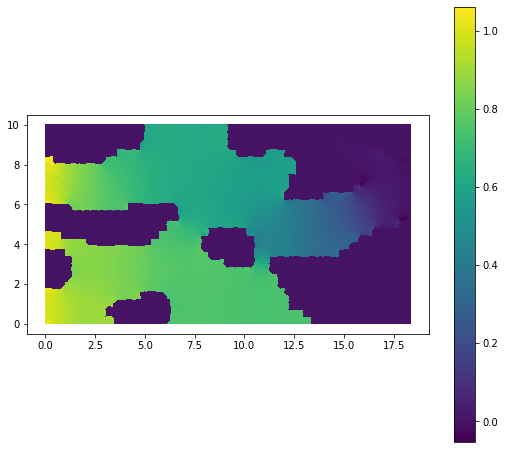

In [7]:
fig = plt.figure(figsize=(9,8))
cb = plot(pressure)
#plot(u)
fig.colorbar(cb)
plt.show()